### IMPORT DE BIBLIOTECAS

In [2]:
from collections import defaultdict
import pandas as pd
import numpy as np
import os

import implicit

from implicit.evaluation import (train_test_split, 
                                 ndcg_at_k, AUC_at_k, 
                                 mean_average_precision_at_k, 
                                 precision_at_k)

from implicit.nearest_neighbours import (bm25_weight, 
                                         CosineRecommender, 
                                         TFIDFRecommender, 
                                         BM25Recommender, 
                                         ItemItemRecommender)

from scipy.sparse import (csr_matrix, 
                          save_npz, 
                          load_npz)
import scipy.stats

from matplotlib import pyplot as plt
import seaborn as sns

import pickle
from tqdm import tqdm
import warnings

In [3]:
warnings.filterwarnings('ignore')

### Carregamento de dados de categorias e histórico de clicks

In [4]:
df_de_cat = pd.read_csv(os.getcwd()+'/new_category_sample.csv') # DataFrame Informativo das categorias

In [5]:
clicks_de = pd.read_csv(os.getcwd()+'/.txt/clicks_de_sample_2.txt', sep = ',', header=0) # df de histórico de clicks
clicks_de.columns

Index(['UserId', 'OfferId', 'OfferViewId', 'CountryCode', 'Category', 'Source',
       'UtcDate', 'Keywords', 'OfferTitle'],
      dtype='object')

In [6]:
clicks_de.columns = ['UserId', 'OfferId', 'OfferViewId', 'CountryCode', 'Category', 'Source',
       'UtcDate', 'Keywords', 'OfferTitle']

Valores missing na coluna de OfferTitle que serão excluídos.

In [7]:
clicks_de = clicks_de[clicks_de.OfferTitle.isna() == False]

### Merge do Dataframe de categorias com o dataframe de clicks 

In [8]:
clicks_de = clicks_de.merge(df_de_cat, on = 'Category')

### CRIAÇÃO DE COLUNA DE CLICKS POR CATEGORIA

In [9]:
clicks_de.drop(columns = ['Keywords'], axis = 1, inplace=True)  # DROP DAS KEYWORDS

df_de_cat.rename({'Ancertor_ID':'Ancestor_ID'}, axis = 1, inplace = True) # RENAME DO ANCESTOR_ID

#df_de_cat.drop('Unnamed: 0', axis =1, inplace = True) # Remoção de coluna Unnamed

clicks_de['Cat_clicks'] = clicks_de.groupby('Category')['OfferId'].transform('count') # Criação de coluna de clicks por categoria

KeyError: "['Unnamed: 0'] not found in axis"

### Criação de coluna com o nº total de clicks do usuário e nº total de clicks do produto

In [10]:
clicks_de['UserTotalClicks'] = clicks_de.groupby(by=['UserId'])['OfferId'].transform('count')

In [11]:
clicks_de['ProductClicks'] = clicks_de.groupby(by=['OfferId'])['UserId'].transform('count')

In [12]:
#clicks_de = clicks_de[clicks_de.ProductClicks < clicks_de.ProductClicks.mean() + 1.5*scipy.stats.iqr(clicks_de.ProductClicks)]

In [13]:
#clicks_de = clicks_de_filtered[(clicks_de_filtered.ProductClicks < clicks_de_filtered.ProductClicks.mean() + 3*clicks_de_filtered.ProductClicks.std())]

In [57]:
clicks_de_filtered.ProductClicks.mean() + 3*clicks_de_filtered.ProductClicks.std()

892.0176355399199

In [58]:
clicks_de.ProductClicks.mean() + 1.5*scipy.stats.iqr(clicks_de.ProductClicks)

130.02519928116436

In [38]:
#Cap minimo de clicks para integrar o sistema de recomendação
clicks_de_filtered = clicks_de[(clicks_de.UserTotalClicks > 30)]

### Conversão das colunas de usuário e oferta em categórica e criando novas colunas com os códigos adotados 

In [36]:
clicks_de.UserId = clicks_de.UserId.astype('category')
clicks_de.OfferId = clicks_de.OfferId.astype('category')
clicks_de.Category = clicks_de.Category.astype('category')

In [37]:
clicks_de['User'] = clicks_de.UserId.cat.codes
clicks_de['Offer'] = clicks_de.OfferId.cat.codes
clicks_de['Catcode'] = clicks_de.Category.cat.codes

In [16]:
clicks_de_filtered.UserId = clicks_de_filtered.UserId.astype('category')
clicks_de_filtered.OfferId = clicks_de_filtered.OfferId.astype('category')


clicks_de_filtered['User'] = clicks_de_filtered.UserId.cat.codes
clicks_de_filtered['Offer'] = clicks_de_filtered.OfferId.cat.codes

<AxesSubplot:ylabel='ProductClicks'>

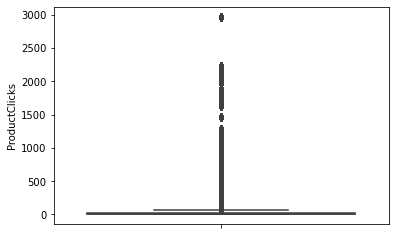

In [17]:
sns.boxplot(y = clicks_de.ProductClicks)


### Agrupamento de dos clicks de usuário em ofertas únicas para termos a quantidade de cada usuário em cada oferta.


In [39]:
clicks_de_filtered['UserClicks'] = clicks_de_filtered.groupby(by=['User','Offer']).transform('count')['UserTotalClicks']

In [40]:
clicks_de_filtered['UserCatClicks'] = clicks_de_filtered.groupby(by=['User','Category']).transform('count')['Category_Name']

In [41]:
clicks_de_filtered['filha_1'] = clicks_de_filtered['filha_1'].astype('int32')

In [42]:
clicks_de_filtered['filha_1'] = clicks_de_filtered['filha_1'].astype('category')
clicks_de_filtered['Sub1'] = clicks_de_filtered['filha_1'].cat.codes

In [43]:
clicks_per_user_product = clicks_de_filtered.groupby(by=['User','Offer']).count()[['UserTotalClicks']].reset_index().rename({'UserTotalClicks':'UserClicks'}, axis = 1)

In [44]:
clicks_per_user_product['Sub1'] = clicks_per_user_product.Offer.map(dict(zip(clicks_de_filtered.Offer, clicks_de_filtered.Sub1)))

In [45]:
clicks_per_user_product

,User,Offer,UserClicks,Sub1
0,8,11060,3,2
1,8,42527,3,7
2,8,60910,3,16
3,8,68986,1,12
4,8,124373,3,20
...,...,...,...,...
64721,415539,204720,3,16
64722,415539,227339,3,13
64723,415539,238740,2,8
64724,415539,293000,3,7


In [46]:
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score, recall_at_k
from lightfm.cross_validation import random_train_test_split

dataset = Dataset()
dataset.fit(clicks_per_user_product.User.unique(), clicks_per_user_product.Offer.unique(), item_features = uf)
(interactions, weights) = dataset.build_interactions(zip(clicks_per_user_product.User, clicks_per_user_product.Offer, clicks_per_user_product.Sub1))


NameError: name 'uf' is not defined

In [ ]:
train, test = random_train_test_split(interactions, test_percentage = 0.2)

In [ ]:
uf = []
col = ['Sub1']*len(clicks_per_user_product.Sub1.unique())
unique_f1 = list(clicks_per_user_product.Sub1.unique())
#print('f1:', unique_f1)
for x,y in zip(col, unique_f1):
    res = str(x)+ ":" +str(y)
    uf.append(res)
    print(res)

In [71]:
def feature_colon_value(my_list):
    """
    Takes as input a list and prepends the columns names to respective values in the list.
    For example: if my_list = [1,1,0,'del'],
    resultant output = ['f1:1', 'f2:1', 'f3:0', 'loc:del']
   
    """
    result = []
    ll = ['Sub1:']
    aa = my_list
    for x,y in zip(ll,aa):
        res = str(x) +""+ str(y)
        result.append(res)
    return result

In [ ]:
ad_subset = clicks_per_user_product[["Sub1"]]
ad_list = [list(x) for x in ad_subset.values]
feature_list = []
for item in ad_list:
    feature_list.append(feature_colon_value(item))
print(f'Final output: {feature_list}')

In [82]:
item_tuple = list(zip(clicks_per_user_product.User, feature_list))

In [83]:
item_features = dataset.build_item_features(item_tuple, normalize = False)

In [88]:
model = LightFM(loss='warp')

In [89]:
model.fit(interactions, item_features=item_features, sample_weight = weights, epochs = 10)

In [90]:
from lightfm.evaluation import auc_score
train_auc = auc_score(model,
                      interactions,
                      item_features=user_features
                     ).mean()

print('Hybrid training set AUC: %s' % train_auc)

Hybrid training set AUC: 0.9052516


In [91]:
from lightfm.evaluation import precision_at_k

train_precision = precision_at_k(model,
                      interactions,
                      item_features=user_features
                     ).mean()

print('Hybrid training set Precision: %s' % train_precision)

Hybrid training set AUC: 0.005611527


### Criação de matrizes esparsas Usuário-item e item-usuário

In [47]:
alpha = 40 ### (dado, (linhas, colunas))
sparse_item_user = csr_matrix((clicks_per_user_product['UserClicks'], (clicks_per_user_product['Offer'], clicks_per_user_product['User'])))
sparse_user_item = csr_matrix((clicks_per_user_product['UserClicks'], (clicks_per_user_product['User'], clicks_per_user_product['Offer'])))

sparse_user_item = (sparse_user_item*alpha).astype('double') # Conversão de tipo para que o modelo ALS funcione corretamente
#data = (sparse_item_user*alpha).astype('double') # Conversão de tipo para que o modelo ALS funcione corretamente

In [48]:
# weight the matrix, both to reduce impact of users that have played the same artist thousands of times
# and to reduce the weight given to popular items
# item_user_clicks = bm25_weight(data, K1=100, B=0.8)
# get the transpose since the most of the functions in implicit expect (user, item) sparse matrices instead of (item, user)
# user_clicks = item_user_clicks.T.tocsr()

In [49]:
#Esparsidade de matriz
possible_interactions = sparse_item_user.shape[0]*sparse_item_user.shape[1]
interacted = len(sparse_item_user.nonzero()[0])
sparsity = 1 - interacted/possible_interactions
sparsity

0.9999995215444863

 Mais de 99.99% das interações possíveis entre usuários e produtos na atual base dados não foi ainda realizada. Segundo artigo: For collaborative filtering to work, the maximum sparsity you could get away with would probably be about 99.5% or so. Devemos reavaliar a matriz?

In [50]:
save_npz(os.getcwd()+"/.npz/sparse_user_item.npz", sparse_user_item)
save_npz(os.getcwd()+"/.npz/sparse_item_user.npz", sparse_item_user)

In [51]:
model_path = os.getcwd()+'/.pkl/de_als_model.pkl'

* Criação de diferentes matrizes esparsas para operar com o algoritmo. Usuário-item e item-usuário. Cada uma deve ser usada no momento preciso
* O alfa é o coeficiente de confiabilidade da interação do usuário com um item específico. Valor utilizado fi adotado com base no artigo: https://towardsdatascience.com/alternating-least-square-for-implicit-dataset-with-code-8e7999277f4b. Mas, podemos testar outros valores na validação do modelo.
* Outro artigo de base pra elaboração do modelo: https://medium.com/analytics-vidhya/implementation-of-a-movies-recommender-from-implicit-feedback-6a810de173ac

In [52]:
offers = pickle.load(open(os.getcwd()+"/.pkl/offers.pkl", "rb"))

# FUNÇÃO DE RECOMENDAÇÕES - IMPLICIT

## Treinamento de modelos

Carregamentodo dicionário que converte os códigos de ofertas para o seu título de oferta. Ainda falta traduzir do alemão para o inglês para tirar mais significado dos resultados

In [53]:
def als_model():
    
    '''computes p@k and map@k evaluation metrics and saves model'''
    
    #sparse_item_user = load_npz(os.getcwd()+"/.npz/sparse_item_user.npz")
      
    train, test = implicit.evaluation.train_test_split(sparse_user_item, train_percentage=0.8)

    model = implicit.als.AlternatingLeastSquares()
    
    model.fit(train)

    #with open(model_path, 'wb') as pickle_out:
   #     pickle.dump(model, pickle_out)
    
    return train, test, model

In [54]:
train, test, model = als_model()

  0%|          | 0/15 [00:00<?, ?it/s]

In [55]:
implicit.evaluation.precision_at_k(model, train, test, K = 10)

  0%|          | 0/3723 [00:00<?, ?it/s]

0.0435980168411112

In [24]:
from implicit.als import AlternatingLeastSquares
from implicit.approximate_als import (
    AnnoyAlternatingLeastSquares,
    FaissAlternatingLeastSquares,
    NMSLibAlternatingLeastSquares,
)
from implicit.bpr import BayesianPersonalizedRanking
from implicit.datasets.lastfm import get_lastfm
from implicit.lmf import LogisticMatrixFactorization
from implicit.nearest_neighbours import (
    BM25Recommender,
    CosineRecommender,
    TFIDFRecommender,
    bm25_weight,
)

# maps command line model argument to class name
MODELS = {
    "als": AlternatingLeastSquares,
    "nmslib_als": NMSLibAlternatingLeastSquares,
    "annoy_als": AnnoyAlternatingLeastSquares,
    "faiss_als": FaissAlternatingLeastSquares,
    "tfidf": TFIDFRecommender,
    "cosine": CosineRecommender,
    "bpr": BayesianPersonalizedRanking,
    "lmf": LogisticMatrixFactorization, 
    "bm25": BM25Recommender,
}

In [25]:
def get_model(model_name):
    print(f"getting model {model_name}")
    model_class = MODELS.get(model_name)
    if not model_class:
        raise ValueError(f"Unknown Model '{model_name}'")

    # some default params
    if model_name.endswith("als"):
        params = {"factors": 128, "dtype": np.float32}
    elif model_name == "bm25":
        params = {"K1": 100, "B": 0.5}
    elif model_name == "bpr":
        params = {"factors": 63}
    elif model_name == "lmf":
        params = {"factors": 30, "iterations": 40, "regularization": 1.5}
    else:
        params = {}

    return model_class(**params)

In [73]:
def model_testing():    
    results = []
    for model in MODELS.keys():

        curr_model = get_model(model)
        #logging.debug("training model %s", model)

        curr_model.fit(train)
        partial = model_evaluation(train, test, curr_model)
        #logging.debug("trained model '%s' in %0.2fs", model_name, time.time() - start)
        results.append([model, partial['p@K'],partial['map@K'], partial['ndcg@K'], partial['auc@K']])

    final = pd.DataFrame(results, columns = ['Model','P@K','MAP@K','NDCG@K','AUC@K'])
    
    return final
    

In [74]:
models_performance = model_testing()

NameError: name 'MODELS' is not defined

In [50]:
models_performance

,Model,P@K,MAP@K,NDCG@K,AUC@K
0,als,0.185381,0.042413,0.085241,0.592645
1,nmslib_als,0.079222,0.014352,0.034785,0.537999
2,annoy_als,0.031114,0.014516,0.024354,0.515218
3,faiss_als,0.176005,0.042882,0.083899,0.587948
4,tfidf,0.096556,0.003812,0.025463,0.548564
5,cosine,0.088654,0.003340,0.023343,0.544808
6,bpr,0.130543,0.022395,0.052753,0.563562
7,lmf,0.124835,0.027512,0.055101,0.562234
8,bm25,0.026388,0.001718,0.009489,0.517869


# Avaliação Baseline

In [24]:
def get_k_most_popular(sparse_item_user, k):
    
    """Retorna um array com os códigos dos itens clicados por mais clientes da base de dados"""
    
    new_sparse = sparse_item_user.copy() # Nova esparsa para não modificar a original
    interaction = np.ones_like(new_sparse.data) # Altera os valores da matriz esparsa para '1' se houve interação para que não sejam contadas múltiplas interações do mesmo cliente com o mesmo produto
    new_sparse.data = interaction # Assimila o array de interações de 1's aos dados da matriz esparsa
    pop_items = np.array((new_sparse).sum(axis = 1)).reshape(-1) # Aqui é feita a soma de interações que ocorreram em cada uma das linhas, que correspondem a cada um dos produtos
    most_popular = pd.Series(pop_items).sort_values(ascending = False)[:k] # Os itens são convertidos em série para que possam ser ordenados e então captados os deus com maior incidência para que sejam retornados seus indices(código do produto)
    
    return most_popular.index

 O modelo de baseline considerará como sugestão os produtos mais populares de todo o dataframe como recomendação para todos os clientes

In [25]:
def get_user_top_k(userid, sparse_user_item, k=10):
    
    '''Retorna os top-K produtos clicados por um usuário de acordo 
    com o nível de confiança obtido através das suas interações'''

    top_K =pd.Series(sparse_user_item[userid].data, index = sparse_user_item[userid].indices).sort_values(ascending = False)[:k]
    return top_K.index.values

### Avaliação do modelo

In [27]:
precision_at_k(sparse_item_user, func = model.recommend, k=10,  popularity = True)

0.016250902827934736

In [75]:
def model_evaluation(train, test, model, k=10): 
    
    '''Avaliação do modelo treinado com as funções da biblioteca Implicit.
    Retorna dicionário com p@k, map@k, ndcg@k e auc@k.'''

    
    p_at_k = implicit.evaluation.precision_at_k(model, train_user_items=train, 
                                                test_user_items=test,
                                                K=k, 
                                                show_progress = False)
    
    m_at_k = implicit.evaluation.mean_average_precision_at_k(model, 
                                                             train_user_items = train, 
                                                             test_user_items = test, 
                                                             K=k, 
                                                             show_progress = False)

    ndcg_at_k = implicit.evaluation.ndcg_at_k(model, 
                                              train_user_items = train,
                                              test_user_items = test, 
                                              K=k, 
                                              show_progress = False)

    auc_at_k = implicit.evaluation.AUC_at_k(model, 
                                            train_user_items = train, 
                                            test_user_items = test, 
                                            K=k, 
                                            show_progress = False)
    metrics = {'p@K':p_at_k, 
               'map@K': m_at_k, 
               'ndcg@K':ndcg_at_k, 
               'auc@K':auc_at_k}
    
    return metrics

In [76]:
metrics = model_evaluation(train, test, model)

In [77]:
metrics

{'p@K': 0.15521628498727735,
 'map@K': 0.05056217652455384,
 'ndcg@K': 0.09026699013093022,
 'auc@K': 0.5513669142406108}

* Sobre metricas de precisão @k: https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54
* Sobre NDCG: https://towardsdatascience.com/evaluate-your-recommendation-engine-using-ndcg-759a851452d1
* Sobre Mean Average Precision: https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52

Ainda não foi realizada qualquer tunagem de hiperaparâmetros. Podemos pegar alguns valores de referencia para rodar um gridsearch

## Funções de recomendações

In [43]:
def recommend(user):
    
    ''' Retorna uma lista de itens recomendados para o usuário dado de acordo com a biblioteca Implicit.
        Também é retornado uma lista com os itens já clicados por esse usuário'''
    
    sparse_user_item = load_npz("/.npz/sparse_user_item.npz")
    
    with open(model_path, 'rb') as pickle_in:
        model = pickle.load(pickle_in)
        
    recommended, _ = (model.recommend(user, sparse_user_item[user]))

    original_user_items = list(sparse_user_item[user].indices)

    return recommended, original_user_items

In [47]:
def most_similar_items(item_id, n_similar=10):
    '''computes the most similar items'''
    
    with open(model_path, 'rb') as pickle_in:
        model = pickle.load(pickle_in)

    similar, score = zip(*model.similar_items(item_id, n_similar)[1:])

    return similar

In [218]:
a, b = recommend(208398)

In [219]:
a

array([292786, 201083,  54819, 115844, 163506, 136425,  89779, 246680,
       109613, 219449])

In [220]:
[offers[item] for item in a]

['Hasbro Monopoly Classic Reissue',
 "Marmot Sling shot women's ski jacket in black",
 'Alpinestars WEB GTX touring boots',
 "CasaModa men's shirt Slim Line poplin light blue",
 'Zimtstern Cover snowboard jacket men multicolored',
 'Trekstor SurfTab duo W1 LTE',
 'Tipard YouTube Converter',
 'Samsung SL-C480fw 4-in-1 Color Laser Printer',
 'apple 9',
 'Mercedes-Benz Viano 3.0 CDI compact Autom Trend DPF-Comand-Hitch']

In [ ]:
[offers[item] for item in b]

In [210]:
sparse_item_user.indices

array([357401, 233326,   1941, ..., 208398, 264961, 372104], dtype=int32)

In [43]:
def most_similar_users(user_id, n_similar=10):
    '''computes the most similar users'''
    sparse_user_item = load_npz(os.getcwd()+"/.npz/sparse_user_item.npz")
    
    with open(model_path, 'rb') as pickle_in:
        model = pickle.load(pickle_in)

    similar, _ = zip(*model.similar_users(user_id, n_similar)[1:])

    # original users items
    original_user_items = list(sparse_user_item[user_id].indices)
    
    common_items_users = {}

    # now we want to add the items that a similar user has rated
    for user in similar:
        # Verifica em cada usuário considerado similar quais são os itens que estes
        # tem em comum com o usuário selecionado
        common_items_users[user] = set(list(sparse_user_item[user].indices)) & set(original_user_items)
    
    # retorna usuários similares, e quais são os itens comuns correspondentes a cada um desses usuários
    return similar, common_items_users

In [ ]:
def recalculate_user(user_ratings):
    '''adds new user and its liked items to sparse matrix and returns recalculated recommendations
       Receives the user clicked products vector (user_ratings)''' 

    m = load_npz('sparse_user_item.npz')
    n_users, n_movies = m.shape

    ratings = [alpha for i in range(len(user_ratings))]

    m.data = np.hstack((m.data, ratings))
    m.indices = np.hstack((m.indices, user_ratings))
    m.indptr = np.hstack((m.indptr, len(m.data)))
    m._shape = (n_users+1, n_movies)

    # recommend N items to new user
    with open(model_path, 'rb') as pickle_in:
        model = pickle.load(pickle_in)
        
    recommended, _ =  zip(*model.recommend(n_users, m, recalculate_user=True))
    
    return recommended

* A matriz m passa a ser a matriz com o novo usuário atualizado e é levada em consideração no para o cálculo de novos vetores.

Nota: 
* Após os ajustes na organização das matrizes esparsas, o modelo parece não mais repetir recomendações de itens que já foram clicados pelo usuário
* O modelo parece também não mais necessitar de tradução dos códigos de ofertas e usuário adotados na matriz esparsa para os códigos da matriz original

### Criação e armazenamento do dicionário código-titulo de oferta (carregado na parte de cima do código).

In [156]:
df_temp = clicks_de[['Offer','OfferTitle']]

In [161]:
df_temp = df_temp.drop_duplicates(['Offer','OfferTitle'])

In [169]:
teste_dicio = dict(zip(df_temp['Offer'], df_temp['OfferTitle']))

In [95]:
dic = pd.read_csv('de_traduzido.csv')
dic['Offer2'] = dic['OfferTitle'].map(dict(zip(clicks_de.OfferTitle, clicks_de.Offer)))

In [115]:
pickle.dump(offers, open('.pkl/offers.pkl', 'wb'))

### Tunagem de hiperparametros

In [26]:
grid = {'factors': [10,100,200],
       'regularization':[1, 0.1, 0.01],
        'iterations':[10,30,50], 
        'alphas':[1,15,40,60]}

In [130]:
model = implicit.als.AlternatingLeastSquares()

In [39]:
    def gridsearch_als(grid):
        results = []
        for factor in grid['factors']:
            for regularization in grid['regularization']:
                for iteration in grid['iterations']:
                    for alpha in grid['alphas']:

                        model = implicit.als.AlternatingLeastSquares(factors = factor, 
                                                                     regularization = regularization, 
                                                                     iterations = iteration)
                        model.fit(train*alpha)

                        partial = model_evaluation(train, test, model, )
                        results.append([factor, regularization, iteration, alpha, partial['p@K'],partial['map@K'], partial['ndcg@K'], partial['auc@K']])

        final = pd.DataFrame(results, columns = ['Factors','Regularization','Iteration','alpha','P@K','MAP@K','NDCG@K','AUC@K'])
        return final
                

In [ ]:
grid_results = gridsearch_als(grid)

In [68]:
grid_results.to_csv('params.csv')

In [43]:
grid_results.sort_values(by=['AUC@K', 'P@K'], ascending = False)

,Factors,Regularization,Iteration,alpha,P@K,MAP@K,NDCG@K,AUC@K
37,100,1.00,10,15,0.158265,0.056878,0.081968,0.560005
53,100,0.10,30,15,0.158265,0.056236,0.081127,0.559982
45,100,1.00,50,15,0.155841,0.056002,0.080831,0.559306
49,100,0.10,10,15,0.159234,0.056657,0.081350,0.559191
46,100,1.00,50,40,0.155841,0.053499,0.078452,0.559166
...,...,...,...,...,...,...,...,...
96,200,0.01,10,1,0.105671,0.039097,0.056663,0.540850
100,200,0.01,30,1,0.103248,0.037794,0.055045,0.539358
92,200,0.10,50,1,0.102763,0.037104,0.054335,0.539280
88,200,0.10,30,1,0.101309,0.037504,0.054455,0.539047


In [18]:
from implicit.datasets.lastfm import get_lastfm

In [19]:
artists, users, artist_user_plays = get_lastfm()

In [56]:
artist_plays = load_npz('user_plays.npz')

In [80]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

In [90]:
def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered  

In [135]:
from sklearn import metrics

def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr) 

In [97]:
import random
train, test, altered = make_train(sparse_user_item)

In [120]:
model = implicit.als.AlternatingLeastSquares()

In [121]:
model.fit(train)

  0%|          | 0/15 [00:00<?, ?it/s]

In [128]:
recommends = (model.recommend(altered, sparse_user_item[altered]))

In [59]:
altered

NameError: name 'altered' is not defined

In [138]:
calc_mean_auc(train,altered,[csr_matrix(model.user_factors), csr_matrix(model.item_factors.T)], test)

(0.624, 0.695)

In [131]:
train[altered]

<131x518 sparse matrix of type '<class 'numpy.float64'>'
	with 1464 stored elements in Compressed Sparse Row format>

In [132]:
recommends[0]

array([[445, 308, 266, ..., 312, 406, 282],
       [135, 247, 288, ..., 158, 365, 209],
       [ 27, 346, 297, ..., 485, 279, 334],
       ...,
       [143, 134, 252, ...,  51, 310,   4],
       [ 86, 423, 133, ...,  56, 334, 154],
       [307,  83, 423, ..., 364, 341, 129]])